This notebook connects to an InfluxDB 3 instance and demonstrates a complete data-analysis workflow for real-time vehicle telemetry. It was developed for Western Formula Racing’s electric car, using live CAN-bus signals streamed into InfluxDB.

* Connect securely to an InfluxDB 3 database using environment variables

* Query, explore, and visualize raw telemetry tables

* Merge voltage and current signals to compute instantaneous power

* Detect the highest sustained power output through rolling-window analysis

* Generate interactive 3D Voltage–Current–Time plots with power as color intensity

It’s a self-contained example of Python-based data engineering and visualization for high-frequency IoT datasets, combining Pandas, Matplotlib, Plotly, and SQL over InfluxDB 3.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from influxdb_client_3 import InfluxDBClient3

pio.templates.default = "plotly_white"

# Connect to InfluxDB 3
client = InfluxDBClient3(
    host=os.getenv("INFLUX_SERVER"),
    token=os.getenv("INFLUX_TOKEN"),
    database="WFR25",
)

In [2]:
# Check InfluxDB connection
try:
    # Simple query to test connection
    test_query = client.query("SELECT 1 as test")
    print("Connection to InfluxDB successful!")
    print("Test query result:", test_query)
except Exception as e:
    print(f"Connection failed: {e}")

Connection to InfluxDB successful!
Test query result: pyarrow.Table
test: int64 not null
----
test: [[1]]


In [3]:
# Query to list available tables in the database
# Expecting WFR25, WFR26...
tables = client.query("""
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'iox'
""")

print("Available tables in iox schema:")
print(tables)

Available tables in iox schema:
pyarrow.Table
table_name: string not null
----
table_name: [["WFR25"]]


In [4]:
# Check the schema (data structure) of the WFR25 table
schema_check = client.query("""
    SELECT *
    FROM "iox"."WFR25"
    LIMIT 1
""")

print("Table schema:")
print(schema_check.schema)
print("Sample data:")
print(schema_check)

Table schema:
canId: string
  -- field metadata --
  iox::column::type: 'iox::column_type::tag'
messageName: string
  -- field metadata --
  iox::column::type: 'iox::column_type::tag'
sensorReading: double
  -- field metadata --
  iox::column::type: 'iox::column_type::field::float'
signalName: string
  -- field metadata --
  iox::column::type: 'iox::column_type::tag'
time: timestamp[ns] not null
  -- field metadata --
  iox::column::type: 'iox::column_type::timestamp'
Sample data:
pyarrow.Table
canId: string
messageName: string
sensorReading: double
signalName: string
time: timestamp[ns] not null
----
canId: [["2014"]]
messageName: [["VCU_Front_Sensors_1"]]
sensorReading: [[0.52]]
signalName: [["A1"]]
time: [[2025-05-29 18:30:00.025000192]]


In [5]:
# Query to get the latest 10 entries from WFR25
latest_entries = client.query("""
    SELECT time, "sensorReading", "signalName"
    FROM "iox"."WFR25"
    ORDER BY time DESC
    LIMIT 10
""")

print("Latest 10 entries:")
print(latest_entries)

Latest 10 entries:
pyarrow.Table
time: timestamp[ns] not null
sensorReading: double
signalName: string
----
time: [[2025-09-30 02:09:02.293999872,2025-09-30 02:09:02.293999872,2025-09-30 02:09:02.293999872,2025-09-30 02:09:02.293999872,2025-09-30 02:09:02.293999872,2025-09-30 02:09:02.293999872,2025-09-30 02:09:02.293999872,2025-09-30 02:09:02.284000000,2025-09-30 02:09:02.284000000,2025-09-30 02:09:02.284000000]]
sensorReading: [[0,0,0,0,0,0,0,0,0,0]]
signalName: [["VCU_INV_Direction_Command","VCU_INV_Inverter_Enable","VCU_INV_Torque_Limit_Command","VCU_INV_Torque_Command","VCU_INV_Speed_Command","VCU_INV_Speed_Mode_Enable","VCU_INV_Inverter_Discharge","VCU_INV_Direction_Command","VCU_INV_Speed_Mode_Enable","VCU_INV_Speed_Command"]]


In [6]:
from datetime import datetime, timedelta

# A better, memory safe way to get all unique signalNames
# Adjust these based on your date(s) of interest
start_date = datetime(2025, 6, 19)
end_date   = datetime(2025, 7, 10)
window_days = 7  # one-week window per query

unique_signals = set()

# Change WFR25 to WFR26, etc. for the year that you are interested in.
TABLE = "iox"
CAR_YEAR = "WFR25"

# Initialize current date
current = start_date
while current < end_date:
    next_window = current + timedelta(days=window_days)
    query = f"""
        SELECT DISTINCT "signalName"
        FROM "{TABLE}"."{CAR_YEAR}"
        WHERE time >= '{current.isoformat()}Z'
          AND time < '{next_window.isoformat()}Z'
        LIMIT 5000
    """
    try:
        result = client.query(query)
        df = result.to_pandas()
        if not df.empty:
            unique_signals.update(df["signalName"].unique())
        print(f"{current.date()} → {next_window.date()} : {len(df)} signals")
    except Exception as e:
        print(f"{current.date()} → {next_window.date()} failed: {e}")
    current = next_window

print(f"Total unique signals: {len(unique_signals)}")
# print(sorted(unique_signals))

2025-06-19 → 2025-06-26 : 362 signals
2025-06-26 → 2025-07-03 : 0 signals
2025-07-03 → 2025-07-10 : 384 signals
Total unique signals: 404


In [7]:
# Query to find the highest historical value of signal 'INV_DC_Bus_Voltage'
max_value_table = client.query("""
    SELECT MAX("sensorReading") as max_value
    FROM "iox"."WFR25"
    WHERE "signalName" = 'INV_DC_Bus_Voltage'
""")

print("Max value query result:")
print(max_value_table)

Max value query result:
pyarrow.Table
max_value: double
----
max_value: [[860.9000000000001]]


860V?? That could be an error. Let's take a look at 99.9th percentile.

In [8]:
# Query to find the 99.9th percentile of signal 'INV_DC_Bus_Voltage'
percentile_999_table = client.query("""
    SELECT APPROX_PERCENTILE_CONT("sensorReading", 0.999) as percentile_999
    FROM "iox"."WFR25"
    WHERE "signalName" = 'INV_DC_Bus_Voltage'
""")

print("99.9th percentile query result:")
print(percentile_999_table)
print("That looks so much better.")

99.9th percentile query result:
pyarrow.Table
percentile_999: double
----
percentile_999: [[],[406.78847596318076]]
That looks so much better.


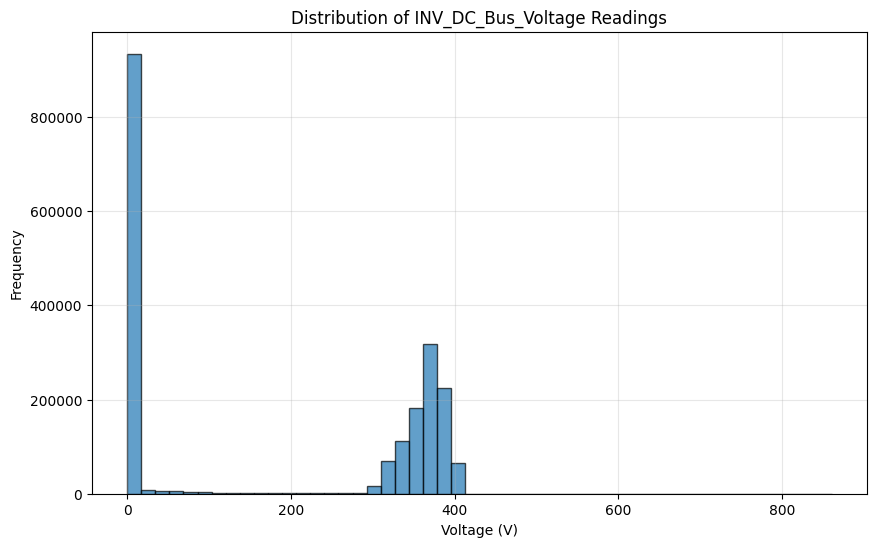

In [9]:
# Query all voltage readings for histogram
voltage_histogram_data = client.query("""
    SELECT "sensorReading"
    FROM "iox"."WFR25"
    WHERE "signalName" = 'INV_DC_Bus_Voltage'
""")

# Convert to pandas for plotting
voltage_df = voltage_histogram_data.to_pandas()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(voltage_df['sensorReading'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of INV_DC_Bus_Voltage Readings')
plt.xlabel('Voltage (V)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
# Query all historical voltage data
voltage_data = client.query("""
    SELECT time, "sensorReading"
    FROM "iox"."WFR25"
    WHERE "signalName" = 'INV_DC_Bus_Voltage'
    ORDER BY time
""")

# Query all historical current data
current_data = client.query("""
    SELECT time, "sensorReading"
    FROM "iox"."WFR25"
    WHERE "signalName" = 'INV_DC_Bus_Current'
    ORDER BY time
""")

# Convert both to pandas
df_v = voltage_data.to_pandas().rename(columns={"sensorReading": "voltage"}).set_index("time")
df_c = current_data.to_pandas().rename(columns={"sensorReading": "current"}).set_index("time")

# Merge on time (inner join to align timestamps)
df = pd.merge_asof(df_v.sort_index(), df_c.sort_index(),
                   left_index=True, right_index=True,
                   direction="nearest", tolerance=pd.Timedelta("100ms"))

# Compute power
df["power"] = df["voltage"] * df["current"]

In [11]:
def analyze_sustained_power(df, window_seconds, min_points=20, metric='median'):
    """
    Analyze the highest sustained power over a rolling window.

    Args:
        df: DataFrame with 'power' column and datetime index
        window_seconds: Size of the rolling window in seconds
        min_points: Minimum number of points required in the window
        metric: 'mean' or 'median' for aggregation

    Returns:
        max_result: Maximum aggregated power in the window (or None if no valid windows)
        start_time: Start of the period
        end_time: End of the period
        count: Number of values in the window
    """

    if metric == 'mean':
        rolling_agg = df["power"].rolling(f"{window_seconds}s").mean()
    elif metric == 'median':
        rolling_agg = df["power"].rolling(f"{window_seconds}s").median()
    else:
        raise ValueError("Metric must be 'mean' or 'median'")

    rolling_count = df["power"].rolling(f"{window_seconds}s").count()

    # Filter to windows with at least min_points
    valid_windows = rolling_count >= min_points

    if not valid_windows.any():
        print(f"No windows with at least {min_points} points found for {window_seconds}s.")
        return None, None, None, None

    # Find max among valid windows
    max_result = rolling_agg[valid_windows].max()
    max_time = rolling_agg[valid_windows].idxmax()

    start_time = max_time - pd.Timedelta(seconds=window_seconds)
    end_time = max_time

    count = rolling_count.loc[max_time]

    return max_result, start_time, end_time, count

# Example usage with 5 seconds, using median
max_result, start_time, end_time, count = analyze_sustained_power(df, 5, metric='median')

if max_result is not None:
    print(f"Highest sustained 2s median power: {max_result:.2f} W")
    print(f"Number of values in the 2s window: {count}")
    print(f"Period start: {start_time}")
    print(f"Period end: {end_time}")

# Compare with other parameters
max_median_5s, _, _, _ = analyze_sustained_power(df, 5, metric='median')
if max_median_5s is not None:
    print(f"\nFor comparison, highest sustained 5s median: {max_median_5s:.2f} W")
max_mean_5s, _, _, _ = analyze_sustained_power(df, 5, metric='mean')
if max_mean_5s is not None:
    print(f"\nFor comparison, highest sustained 5s mean: {max_mean_5s:.2f} W")

Highest sustained 2s median power: 34862.67 W
Number of values in the 2s window: 238.0
Period start: 2025-06-15 16:19:16.826999808
Period end: 2025-06-15 16:19:21.826999808

For comparison, highest sustained 5s median: 34862.67 W

For comparison, highest sustained 5s mean: 32922.45 W


Period start: 2025-06-15 16:19:16.826999808
Period end: 2025-06-15 16:19:21.826999808
Data points in period: 238
Sample data:
                               voltage  current  power
time                                                  
2025-06-15 16:19:16.838000128    388.8      0.0   0.00
2025-06-15 16:19:16.859000064    388.6      0.1  38.86
2025-06-15 16:19:16.896000000    388.8      0.0   0.00
2025-06-15 16:19:16.900999936    388.5     -0.1 -38.85
2025-06-15 16:19:16.921999872    388.7     -0.1 -38.87


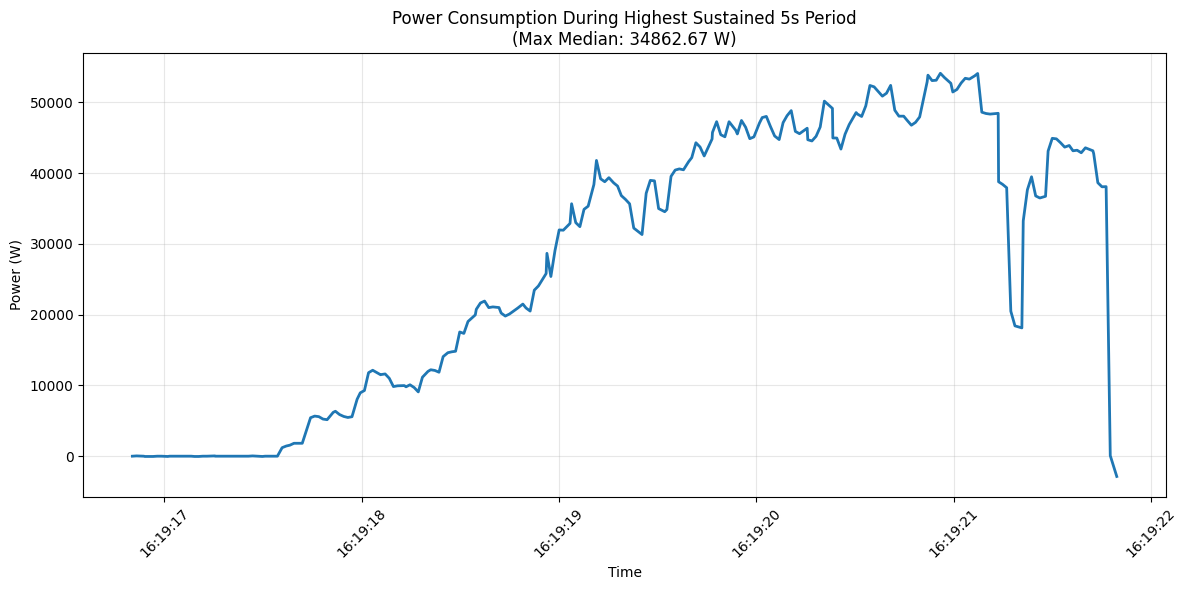

In [12]:
# Filter the dataframe to the 5-second period of highest sustained power
period_df = df.loc[start_time:end_time]

print(f"Period start: {start_time}")
print(f"Period end: {end_time}")
print(f"Data points in period: {len(period_df)}")
print("Sample data:")
print(period_df.head())

# Plot the power over time for this period
plt.figure(figsize=(12, 6))
plt.plot(period_df.index, period_df['power'], linewidth=2)
plt.title(f'Power Consumption During Highest Sustained 5s Period\n(Max Median: {max_result:.2f} W)')
plt.xlabel('Time')
plt.ylabel('Power (W)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3D Plots

The 3D plot is from the same susbet of data as above.

In [13]:
# Pick data window
if 'period_df' in globals() and isinstance(period_df, pd.DataFrame) and len(period_df) > 0:
    plot_df = period_df.copy()
    window_label = "Peak 5 s window"
else: # Safeguard
    N = 8000
    plot_df = df.tail(N).copy()
    window_label = f"Last {min(len(df), N)} samples"

required = {'voltage', 'current', 'power'}
missing = required - set(plot_df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

plot_df = plot_df.dropna(subset=['voltage', 'current', 'power']).sort_index()

max_points = 2000
if len(plot_df) > max_points:
    step = max(1, len(plot_df) // max_points)
    plot_df = plot_df.iloc[::step]

# Convert DatetimeIndex to seconds since start
if isinstance(plot_df.index, pd.DatetimeIndex):
    t0 = plot_df.index[0]
    plot_df['time_s'] = (plot_df.index - t0).total_seconds()
else:
    plot_df['time_s'] = np.arange(len(plot_df))

time_str = plot_df.index.strftime('%Y-%m-%d %H:%M:%S.%f').str[:-3]

smooth_window = '200ms'
if isinstance(plot_df.index, pd.DatetimeIndex):
    plot_df['power_smooth'] = plot_df['power'].rolling(smooth_window).median().bfill()
else:
    plot_df['power_smooth'] = plot_df['power']

# 3D: Voltage–Current–Time
traj_trace = go.Scatter3d(
    x=plot_df['voltage'],
    y=plot_df['current'],
    z=plot_df['time_s'],
    mode='lines+markers',
    name='V–I–t trajectory',
    line=dict(width=2),
    marker=dict(
        size=3,
        color=plot_df['power'],   # color by power
        colorscale='Viridis',
        colorbar=dict(title='Power (W)'),
        opacity=0.9
    ),
    customdata=np.stack(
        [time_str, plot_df['voltage'].values, plot_df['current'].values, plot_df['power'].values],
        axis=1
    ),
    hovertemplate=(
        "Time: %{customdata[0]}<br>"
        "V: %{customdata[1]:.1f} V<br>"
        "I: %{customdata[2]:.1f} A<br>"
        "P: %{customdata[3]:.1f} W<extra></extra>"
    )
)

# Layout
fig = go.Figure(data=[traj_trace])

fig.update_layout(
    title=f"3D Voltage–Current–Time Trajectory • {window_label}",
    scene=dict(
        xaxis_title="Voltage (V)",
        yaxis_title="Current (A)",
        zaxis_title="Time (s)",
        aspectmode='cube',
        xaxis=dict(gridcolor='rgba(0,0,0,0.2)'),
        yaxis=dict(gridcolor='rgba(0,0,0,0.2)'),
        zaxis=dict(gridcolor='rgba(0,0,0,0.2)')
    ),
    margin=dict(l=0, r=0, t=60, b=0),
    annotations=[
        dict(
            text="Color represents instantaneous power (P = V×I).",
            x=0, y=1.08, xref="paper", yref="paper", showarrow=False, align="left"
        )
    ]
)

fig.update_scenes(camera=dict(eye=dict(x=1.6, y=1.6, z=1.2)))

# Save fig to output
fig.write_html("output/3d-voltage-current-time.html")
fig.show()